In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 1. 데이터 준비

In [3]:
import os

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
region = pd.DataFrame()
region['lat']= train['lat']
region['long']=train['long']

In [6]:
region

,lat,long
0,47.5112,-122.257
1,47.7379,-122.233
2,47.6168,-122.045
3,47.3097,-122.327
4,47.4095,-122.315
...,...,...
15030,47.5137,-122.167
15031,47.5537,-122.398
15032,47.6993,-122.346
15033,47.5107,-122.362


In [7]:
# 지역별 클러스터링을 해볼까?

from sklearn.cluster import KMeans 
km = KMeans(n_clusters=10)

km.fit(region)

KMeans(n_clusters=10)

In [8]:
km.cluster_centers_

array([[  47.52017283, -122.17504314],
       [  47.68881324, -122.33678843],
       [  47.36663535, -122.17888988],
       [  47.58673758, -122.04726538],
       [  47.33954539, -122.32476109],
       [  47.70842486, -122.02022207],
       [  47.53651859, -122.33469181],
       [  47.70475654, -122.18774853],
       [  47.33649117, -122.03413417],
       [  47.5183491 , -121.81411312]])

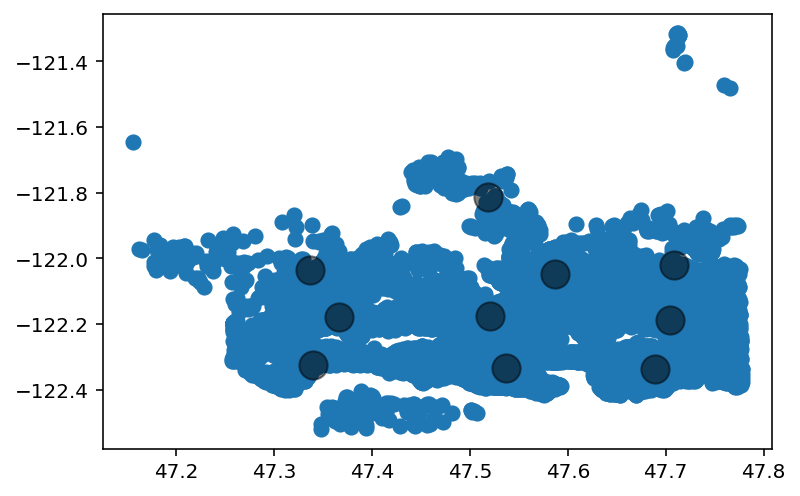

In [9]:
plt.scatter(region.iloc[:, 0], region.iloc[:, 1], s=50)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='black', s=200, alpha=0.5)
plt.savefig("clusterflop")

In [10]:
train['cluster'] = km.labels_

In [11]:
# date열 정리: 연,월만 남기기

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,cluster
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,6
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,7
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,3
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,4
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4


In [12]:
# 타겟데이터를 y에 넣고 train 데이터에서는 지우기

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'cluster'],
      dtype='object')


In [13]:
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'cluster'],
      dtype='object')


In [14]:
# test 데이터도 정리해주기

test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

del test['id']

print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [15]:
region = pd.DataFrame()
region['lat']= test['lat']
region['long']=test['long']

km = KMeans(n_clusters=10)

km.fit(region)

test['cluster'] = km.labels_

In [16]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

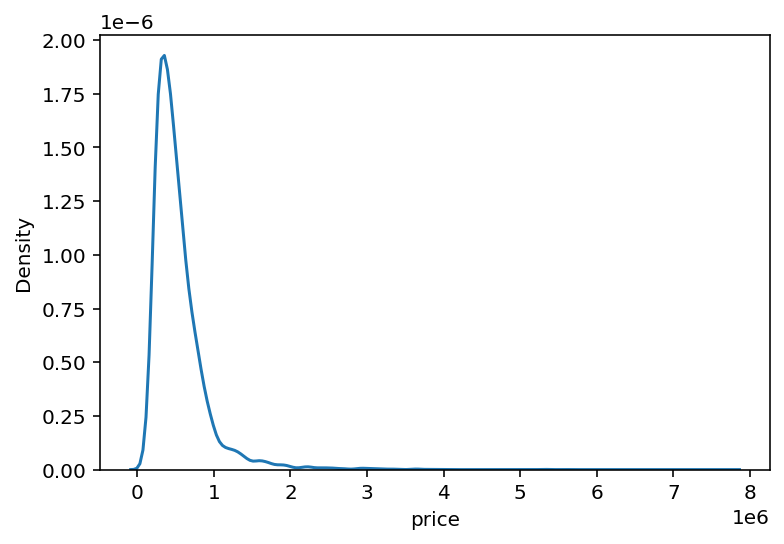

In [17]:
# 타겟 데이터의 분포 확인하기
sns.kdeplot(y)
plt.show()

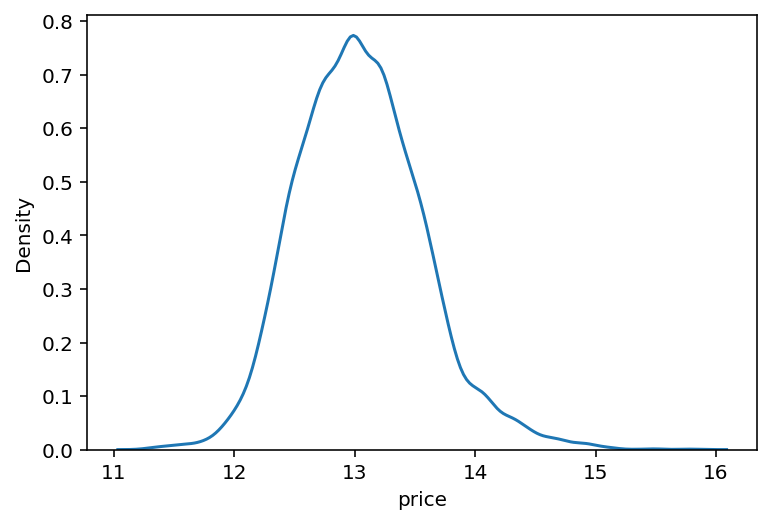

In [18]:
# 한쪽으로 치우친 데이터 정리해주기
y = np.log1p(y)
sns.kdeplot(y)
plt.show()

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

# 2. Function-izing for various experiments

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [21]:
# rmse 구하는 함수 만들기

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [22]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [23]:
# 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줌.
# 시도마다의 성능을 제대로 비교하기 위해 랜덤시드 설정해줌.

random_state = 2022

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


# 각 모델별로 학습 및 예측하는 함수 만들기

def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,136280.247438
XGBRegressor,131007.366071
GradientBoostingRegressor,129025.793198
LGBMRegressor,123519.579646


# 3. Grid Search for Hyperparameter tuning

In [24]:
# 그리드서치로 하이퍼 파라미터를 다양하게 조합해보자
from sklearn.model_selection import GridSearchCV

In [25]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, 100],
}

model = LGBMRegressor(random_state=random_state)

In [26]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2022), n_jobs=5,
             param_grid={'max_depth': [10, 100], 'n_estimators': [100, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [27]:
# 실험에 대한 결과는 다음과 같이 grid_model.cv_results_ 안에 저장됨
grid_model.cv_results_

{'mean_fit_time': array([0.76809421, 1.27473269, 0.63741975, 1.47573438]),
 'std_fit_time': array([0.27761068, 0.06154924, 0.08326531, 0.18367196]),
 'mean_score_time': array([0.05389776, 0.10261936, 0.06320648, 0.07480993]),
 'std_score_time': array([0.02398228, 0.00223726, 0.01998977, 0.01716874]),
 'param_max_depth': masked_array(data=[10, 10, 100, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100, 300, 100, 300],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_depth': 10, 'n_estimators': 100},
  {'max_depth': 10, 'n_estimators': 300},
  {'max_depth': 100, 'n_estimators': 100},
  {'max_depth': 100, 'n_estimators': 300}],
 'split0_test_score': array([-0.02638379, -0.02594862, -0.02640875, -0.02565856]),
 'split1_test_score': array([-0.02831083, -0.02740321, -0.02842645, -0.02756214]),
 'split2_test_score': array(

In [28]:
# params랑 score만 빼서 확인하기

params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,10,100,-0.027121
1,10,300,-0.026227
2,100,100,-0.027120
3,100,300,-0.026122


In [29]:
results['RMSE'] = np.sqrt(-1 * results['score']) # neg_mean_squared_error를 RMSE로 바꿔주기
results = results.rename(columns={'RMSE': 'RMSLE'}) # Root Mean Squared Log Error로 컬럼명 바꿔주기
results = results.sort_values('RMSLE') # 오름차순으로 정렬
results

,max_depth,n_estimators,score,RMSLE
3,100,300,-0.026122,0.161622
1,10,300,-0.026227,0.161949
2,100,100,-0.027120,0.164681
0,10,100,-0.027121,0.164686


In [30]:
# 위 다섯 블록의 과정을 함수로 만듬

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

# 4. 제출하는 것도, 빠르고 깔끔하게!

In [31]:
# 간단히 그리드 탐색

param_grid = {
    'n_estimators': [10, 50, 100, 250, 500, 1000],
    'max_depth': [10, 30, 50, 100],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


,max_depth,n_estimators,score,RMSLE
21,100,250,-0.026220,0.161927
15,50,250,-0.026220,0.161927
9,30,250,-0.026220,0.161927
16,50,500,-0.026221,0.161930
22,100,500,-0.026221,0.161930
10,30,500,-0.026221,0.161930
3,10,250,-0.026287,0.162134
4,10,500,-0.026398,0.162474
11,30,1000,-0.026721,0.163465
17,50,1000,-0.026721,0.163465


가장 좋은 조합: max_depth=100, n_estimators=250 / max_depth=50, n_estimators=250 / max_depth=30, n_estimators=250

In [32]:
model = LGBMRegressor(max_depth=30, n_estimators=250, random_state=random_state)

In [33]:
model.fit(train, y)
prediction = model.predict(test)
prediction

array([13.12207942, 13.13303348, 14.15843168, ..., 13.07744635,
       12.82548087, 13.01778574])

In [34]:
# 예측 결과에 np.expm1()을 씌워서 다시 원래 스케일로 되돌리기

prediction = np.expm1(prediction)
prediction

array([ 499857.0428026 ,  505362.61439069, 1409056.61636893, ...,
        478037.4049443 ,  371564.65987724,  450351.43347421])

In [35]:
# 샘플 데이터를 가져와서 거기에 우리의 결과를 덮어씌우기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

submission['price'] = prediction
submission.head()

,id,price
0,15035,4.998570e+05
1,15036,5.053626e+05
2,15037,1.409057e+06
3,15038,3.077652e+05
4,15039,3.371787e+05


In [38]:
# 위의 데이터를 csv파일로 저장하기

submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.161927')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.161927.csv


In [39]:
# 위의 네 블록 과정을 함수로 만들기

"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

# 코드 작성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

# 5. 조정해보자~

In [40]:
# 그리드 탐색
param_grid = {
    'n_estimators': [250,500],
    'max_depth': [30],
    'learning_rate': [0.05,0.1],
    'num_leaves': [100,1000],
    'boosting_type':['gbdt']
}

# 무슨 모델을 쓸까?
model = LGBMRegressor(random_state=random_state)

# 최적의 파라미터를 찾아보자
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,boosting_type,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,gbdt,0.05,30,250,100,-0.026690,0.163371
2,gbdt,0.05,30,500,100,-0.026841,0.163833
4,gbdt,0.10,30,250,100,-0.027401,0.165532
6,gbdt,0.10,30,500,100,-0.027838,0.166848
1,gbdt,0.05,30,250,1000,-0.028366,0.168423
3,gbdt,0.05,30,500,1000,-0.028551,0.168970
5,gbdt,0.10,30,250,1000,-0.029139,0.170700
7,gbdt,0.10,30,500,1000,-0.029319,0.171228


[CV] END ......................max_depth=10, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=10, n_estimators=50; total time=   0.4s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=100; total time=   0.6s
[CV] END .....................max_depth=10, n_estimators=500; total time=   2.2s
[CV] END .....................max_depth=10, n_estimators=500; total time=   2.2s
[CV] END ......................max_depth=30, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=30, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=10; total time=   0.2s
[CV] END ......................max_depth=30, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=10; total time=   0.1s
[CV] END ......................max_depth=30, n_estimators=50; total time=   0.3s
[CV] END ...................

In [41]:
# 모델에 하이퍼 파라미터 넣어주기
model = LGBMRegressor(max_depth=30, 
                      n_estimators=250, 
                      learning_rate=0.05,
                      num_leaves=100,
                      boosting_type='gbdt',
                      random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.163371')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.163371.csv saved!


# 6. 회고

#### 데이터 전처리
데이터 전처리를 할 때 lat, lon 열 정보로 집들을 n=10로 클러스터링 해서 이게 어느 지역이다 라고 하는 새로운 열을 만들어 넣었다. 
만들어 넣기 전 데이터로는 lowest RMSLE 가 0.163503 이었는데, 만들어 넣은 후 데이터로 0.161927로 조금 떨어지는 것을 발견!

#### 그리드서치
- 'n_estimators'
- 'max_depth'
- 'learning_rate'
- 'num_leaves'
- 'boosting_type'

를 모두 조정해보면서 돌려보았는데, max_depth=30, n_estimators=250 만 한 것이 가장 성능이 좋은 느낌..

#### 앙상블 / 모델 스태킹
모델 스태킹은 좀 더 공부를 하고 도전해보아야겠다..

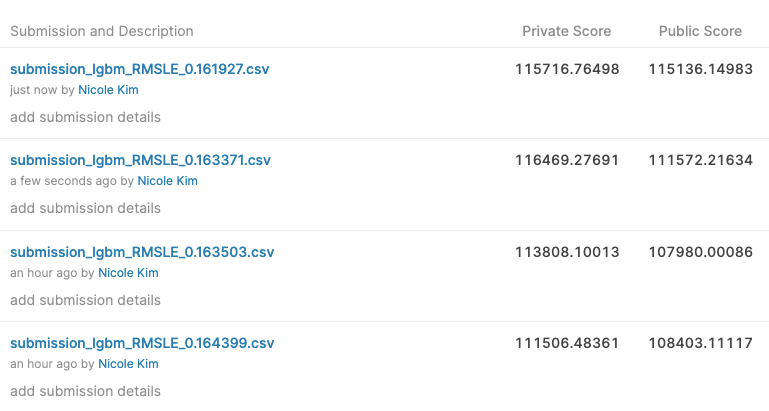

In [42]:
from IPython.display import Image
Image(filename='result.png')

RMSLE가 낮다고 해서 무조건 캐글 스코어가 좋은것은 아니구나....